# Compare OSSE for GLONet : Model Forecast error


In [1]:
import xarray as xr

## Load datasets

In [2]:
# 1. Load the analyzed forecast dataset
analyzed_forecast = xr.open_dataset("/Odyssey/private/j25lee/glonet/output/osse/case_1_further/forecast_4days_from_2025-07-17.nc")

# 2. Load the model dataset
model = xr.open_dataset("/Odyssey/private/j25lee/glonet/output/osse/case_1_further/repeated_forecast_7days_from_2025-07-14.nc")

# 3. Load the glo12 dataset
path = "/Odyssey/public/glonet/2025-07-21_init_states_natureformat"# Read the three input files from the given path

input_list = ["input1.nc", "input2.nc", "input3.nc"]
input_files = [xr.open_dataset(f"{path}/{file}") for file in input_list]

depth_data = xr.concat([input_files[0].drop_vars(["zos"]).expand_dims(depth=[analyzed_forecast.depth[0].values]), input_files[1], input_files[2]], dim="depth")
final_data = xr.merge([input_files[0].zos.to_dataset(), depth_data])


In [3]:
corrected = analyzed_forecast.isel(time=-1)
glo12 = final_data.isel(time=-1)
normalrun = model.isel(time=-2)


### Investigate the data wether they are well selected
 ! It is important to see the variables and dimensions in order to right comparasion.

In [4]:
# normalrun #glo12 #corrected

## Visualization of the difference


In [5]:
import matplotlib.pyplot as plt
    
def visualize_two_differences(ds1, ds2, ds3, var, depth_idx=0):
    """
    Visualize the difference (ds1 - ds3) and (ds2 - ds3) for a given variable and depth using subplots.
    Color scale min/max is fixed from ds3.
    """
    
    match var :
        case "zos" :
            cmap_param = "seismic"
        case "thetao" :
            cmap_param = "viridis"
        case "so" :
            cmap_param = "jet"
        case "uo" :
            cmap_param = "coolwarm"
        case "vo" :
            cmap_param = "coolwarm"
            
    a1 = ds1[var].rename(longitude='lon', latitude='lat')
    a2 = ds2[var].rename(longitude='lon', latitude='lat')
    b = ds3[var]
    
    if 'depth' in a1.dims:
        a1 = a1.isel(depth=depth_idx)
        a2 = a2.isel(depth=depth_idx)
        b = b.isel(depth=depth_idx)
        title1 = f'Difference: ds1 - ds3 ({var}, depth={a1.depth.values})'
        title2 = f'Difference: ds2 - ds3 ({var}, depth={a2.depth.values})'
    else:
        title1 = f'Difference: ds1 - ds3 ({var})'
        title2 = f'Difference: ds2 - ds3 ({var})'

    diff1 = a1 - b
    diff2 = a2 - b
    
    vmin = float(diff1.min().values)
    vmax = float(diff1.max().values)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    im1 = axes[0].pcolormesh(diff1['lon'], diff1['lat'], diff1.values, cmap=cmap_param, vmin=vmin, vmax=vmax)
    axes[0].set_title(title1)
    fig.colorbar(im1, ax=axes[0], label=f'{var} difference')
    im2 = axes[1].pcolormesh(diff2['lon'], diff2['lat'], diff2.values, cmap=cmap_param, vmin=vmin, vmax=vmax)
    axes[1].set_title(title2)
    fig.colorbar(im2, ax=axes[1], label=f'{var} difference')
    # plt.show()

    return vmin, vmax

Fix the third argument as the glo12. It is becuase of the difference dimensions name : <p>latitude => lat, longitude => lon</p>

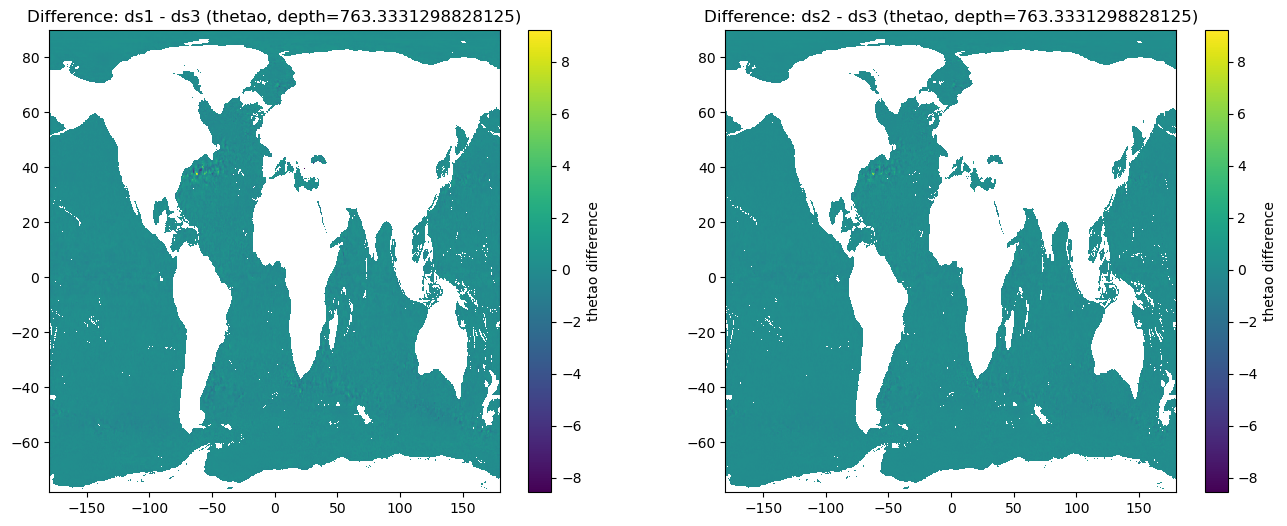

In [16]:
pmin, pmax = visualize_two_differences(normalrun, corrected, glo12, 'thetao', depth_idx=10)

### diffdiff
The visualization above is barely showing the difference. so let's diffdiff to look closer, but in same scale to faire comparaison.

In [13]:

def visualize_diffdifferences(ds1, ds2, pmin, pmax, var, depth_idx=0):
    """
    Visualize the difference (ds1 - ds3) and (ds2 - ds3) for a given variable and depth using subplots.
    Color scale min/max is fixed from ds3.
    """
    
    match var :
        case "zos" :
            cmap_param = "seismic"
        case "thetao" :
            cmap_param = "viridis"
        case "so" :
            cmap_param = "jet"
        case "uo" :
            cmap_param = "coolwarm"
        case "vo" :
            cmap_param = "coolwarm"
            
    a1 = ds1[var].rename(longitude='lon', latitude='lat')
    a2 = ds2[var].rename(longitude='lon', latitude='lat')
    
    if 'depth' in a1.dims:
        a1 = a1.isel(depth=depth_idx)
        a2 = a2.isel(depth=depth_idx)
        
        title1 = f'Difference: ds1 - ds2 ({var}, depth={a1.depth.values})'

    else:
        title1 = f'Difference: ds1 - ds2 ({var})'

    diffdiff = a1 - a2
    
    
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    im1 = axes.pcolormesh(diffdiff['lon'], diffdiff['lat'], diffdiff.values, cmap=cmap_param, vmin=pmin, vmax=pmax)
    axes.set_title(title1)
    fig.colorbar(im1, ax=axes, label=f'{var} difference')

    # plt.show()

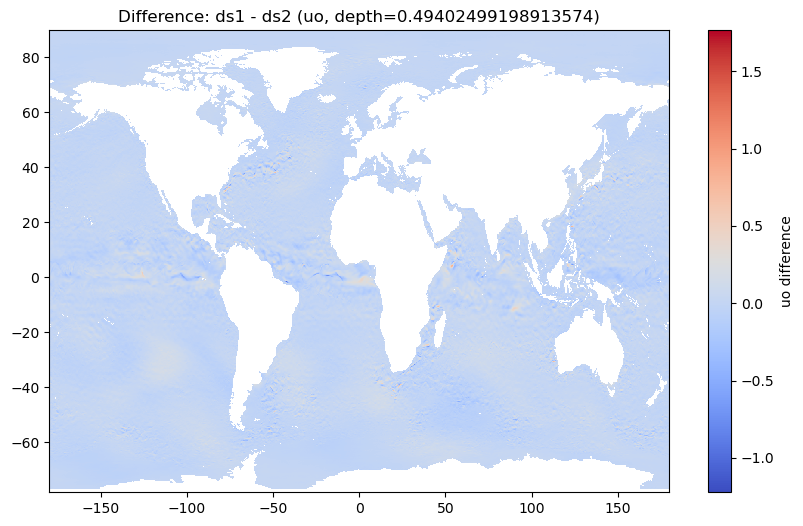

In [15]:
visualize_diffdifferences(normalrun, corrected, pmin, pmax, 'uo', depth_idx=0)

# Quantification of the differences
Investigate the mean, absolute mean value, median, standard deviation, max and min values. </br>
 - Mean value has not much information given the data has both positive and negative values.

In [17]:
import numpy as np

def summarize_difference(forecast, truth):
    summary = {}
    for var in forecast.data_vars:
        if var not in truth.data_vars:
            continue
        a = forecast[var]
        coords_map = {}
        if 'latitude' in a.dims:
            coords_map['latitude'] = 'lat'
        if 'longitude' in a.dims:
            coords_map['longitude'] = 'lon'
        if coords_map:
            a = a.rename(coords_map)
        b = truth[var]
        if set(a.dims) != set(b.dims):
            print(f"Skipping {var}: dimension mismatch")
            continue
        if 'depth' in a.dims:
            stats = {}
            for i, d in enumerate(a.depth.values):
                diff = a.isel(depth=i) - b.isel(depth=i)
                stats[d] = {
                    'mean': float(diff.mean().values),
                    'mean_abs': float(np.abs(diff).mean().values),
                    'median': float(np.median(diff.values)),
                    'std': float(diff.std().values),
                    'max': float(diff.max().values),
                    'min': float(diff.min().values)
                }
            summary[var] = stats
        else:
            diff = a - b
            summary[var] = {
                'mean': float(diff.mean().values),
                'mean_abs': float(np.abs(diff).mean().values),
                'median': float(np.median(diff.values)),
                'std': float(diff.std().values),
                'max': float(diff.max().values),
                'min': float(diff.min().values)
            }
    return summary

In [18]:
def abs_mean_score(forecast, truth):
    """
    Calculate abs_mean(forecast - truth) / abs_mean(truth) and for each variable and by depth if present.
    Returns a dictionary of scores and stds.
    """
    import numpy as np
    score = {}
    for var in forecast.data_vars:
        if var not in truth.data_vars:
            continue
        a = forecast[var]
        coords_map = {}
        if 'latitude' in a.dims:
            coords_map['latitude'] = 'lat'
        if 'longitude' in a.dims:
            coords_map['longitude'] = 'lon'
        if coords_map:
            a = a.rename(coords_map)
        b = truth[var]
        if set(a.dims) != set(b.dims):
            print(f"Skipping {var}: dimension mismatch")
            continue
        if 'depth' in a.dims:
            scores = {}
            for i, d in enumerate(a.depth.values):
                diff = a.isel(depth=i) - b.isel(depth=i)
                abs_mean_diff = float(np.abs(diff).mean().values)
                abs_mean_truth = float(np.abs(b.isel(depth=i)).mean().values)
                # std_diff = float(diff.std().values)
                # std_truth = float(b.isel(depth=i).std().values)
                scores[d] = {
                    'abs_mean_score': abs_mean_diff / abs_mean_truth if abs_mean_truth != 0 else np.nan,
                    # 'std_score': std_diff / std_truth if std_truth != 0 else np.nan
                }
            score[var] = scores
        else:
            diff = a - b
            abs_mean_diff = float(np.abs(diff).mean().values)
            abs_mean_truth = float(np.abs(b).mean().values)
            # std_diff = float(diff.std().values)
            # std_truth = float(b.std().values)
            score[var] = {
                'abs_mean_score': abs_mean_diff / abs_mean_truth if abs_mean_truth != 0 else np.nan,
                # 'std_score': std_diff / std_truth if std_truth != 0 else np.nan
            }
    return score


## normalrun - glo12

### Sea surface height

In [19]:
diff_summary1 = summarize_difference(normalrun, glo12)
diff_summary1["zos"]

{'mean': -0.020140675288837607,
 'mean_abs': 0.044684164884734416,
 'median': nan,
 'std': 0.0590564916406738,
 'max': 0.9206970930099487,
 'min': -1.129183366894722}

### Temperature, salinity and currents
Change the stat value and states to investigate by depth

In [20]:
# For all depths
{depth: stats['mean_abs'] for depth, stats in diff_summary1['thetao'].items()}


{np.float32(0.494025): 0.6340741979245589,
 np.float32(47.37369): 0.6629976369078765,
 np.float32(92.32607): 0.6071304755940508,
 np.float32(155.8507): 0.4518572292198418,
 np.float32(222.4752): 0.3731524907237744,
 np.float32(318.1274): 0.28691339417182643,
 np.float32(380.213): 0.24634675100494086,
 np.float32(453.9377): 0.25849029892880326,
 np.float32(541.0889): 0.1928414939776514,
 np.float32(643.5668): 0.17169740990385637,
 np.float32(763.3331): 0.16392316374480095,
 np.float32(902.3393): 0.16743791433659277,
 np.float32(1245.291): 0.1069092123884933,
 np.float32(1684.284): 0.07726335656429756,
 np.float32(2225.078): 0.06094667045947607,
 np.float32(3220.82): 0.05804819537431932,
 np.float32(3597.032): 0.053307066127693016,
 np.float32(3992.484): 0.0440919261619914,
 np.float32(4405.224): 0.04096197704082407,
 np.float32(4833.291): 0.04117522529420459,
 np.float32(5274.784): 0.2283047718839955}

In [21]:

score_abs_mean1 = abs_mean_score(normalrun, glo12)
score_abs_mean1["thetao"]

{np.float32(0.494025): {'abs_mean_score': 0.0421405028353495},
 np.float32(47.37369): {'abs_mean_score': 0.048161490540824387},
 np.float32(92.32607): {'abs_mean_score': 0.04806077137283307},
 np.float32(155.8507): {'abs_mean_score': 0.04187859972463968},
 np.float32(222.4752): {'abs_mean_score': 0.03949265244488971},
 np.float32(318.1274): {'abs_mean_score': 0.03536982945117626},
 np.float32(380.213): {'abs_mean_score': 0.03327145531772436},
 np.float32(453.9377): {'abs_mean_score': 0.03867268872454829},
 np.float32(541.0889): {'abs_mean_score': 0.032351164224575575},
 np.float32(643.5668): {'abs_mean_score': 0.03252368460947182},
 np.float32(763.3331): {'abs_mean_score': 0.035552906579372205},
 np.float32(902.3393): {'abs_mean_score': 0.04225587067292604},
 np.float32(1245.291): {'abs_mean_score': 0.035721824258806725},
 np.float32(1684.284): {'abs_mean_score': 0.03370605666946101},
 np.float32(2225.078): {'abs_mean_score': 0.03406891722186054},
 np.float32(3220.82): {'abs_mean_score

## Corrected - glo12

In [22]:
diff_summary2 = summarize_difference(corrected, glo12)
diff_summary2["zos"]

{'mean': -0.012879411273531977,
 'mean_abs': 0.03508598630571576,
 'median': nan,
 'std': 0.04775813737354754,
 'max': 0.6225319504737854,
 'min': -1.1313218474388123}

In [23]:
{depth: stats['mean_abs'] for depth, stats in diff_summary2['thetao'].items()}

{np.float32(0.494025): 0.48952129829621255,
 np.float32(47.37369): 0.5044773855531433,
 np.float32(92.32607): 0.44830739664147157,
 np.float32(155.8507): 0.3364621102292213,
 np.float32(222.4752): 0.2819474821656745,
 np.float32(318.1274): 0.2127190476161407,
 np.float32(380.213): 0.1816414482819234,
 np.float32(453.9377): 0.2113159666172654,
 np.float32(541.0889): 0.14231781670647775,
 np.float32(643.5668): 0.12338805283243948,
 np.float32(763.3331): 0.11930386139566425,
 np.float32(902.3393): 0.1242534874396505,
 np.float32(1245.291): 0.07947471311904467,
 np.float32(1684.284): 0.05984061506337625,
 np.float32(2225.078): 0.045545726086604586,
 np.float32(3220.82): 0.046896494912994635,
 np.float32(3597.032): 0.04289319769640648,
 np.float32(3992.484): 0.038310110996027956,
 np.float32(4405.224): 0.03532030593131718,
 np.float32(4833.291): 0.036688087128499004,
 np.float32(5274.784): 0.19256208520638304}

In [24]:
score_abs_mean2 = abs_mean_score(corrected, glo12)
score_abs_mean2["thetao"]

{np.float32(0.494025): {'abs_mean_score': 0.03253353271011018},
 np.float32(47.37369): {'abs_mean_score': 0.03664625856842007},
 np.float32(92.32607): {'abs_mean_score': 0.035488251967015716},
 np.float32(155.8507): {'abs_mean_score': 0.031183659628784385},
 np.float32(222.4752): {'abs_mean_score': 0.0298399560439308},
 np.float32(318.1274): {'abs_mean_score': 0.026223371191564763},
 np.float32(380.213): {'abs_mean_score': 0.02453239308294163},
 np.float32(453.9377): {'abs_mean_score': 0.03161494506131321},
 np.float32(541.0889): {'abs_mean_score': 0.023875292424813333},
 np.float32(643.5668): {'abs_mean_score': 0.023372712012057983},
 np.float32(763.3331): {'abs_mean_score': 0.02587553181539268},
 np.float32(902.3393): {'abs_mean_score': 0.03135752924725994},
 np.float32(1245.291): {'abs_mean_score': 0.026555071089113702},
 np.float32(1684.284): {'abs_mean_score': 0.026105404322980044},
 np.float32(2225.078): {'abs_mean_score': 0.025459857940653204},
 np.float32(3220.82): {'abs_mean_s

### In certain region : Gulf stream
In global scheme, it is hard to tell the performance in reason of canceling out of data (positive + negative value and too many small values). </br>
So, let's investigate the region which has very active dynamic.

In [25]:
normalrun_gulf = normalrun.where((normalrun.longitude > -80) & (normalrun.longitude < -10) & 
                                 (normalrun.latitude > 30) & (normalrun.latitude < 50), drop=True)
corrected_gulf = corrected.where((corrected.longitude > -80) & (corrected.longitude < -10) & 
                                 (corrected.latitude > 30) & (corrected.latitude < 50), drop=True)
glo12_gulf = glo12.where((glo12.lon > -80) & (glo12.lon < -10) & 
                         (glo12.lat > 30) & (glo12.lat < 50), drop=True)

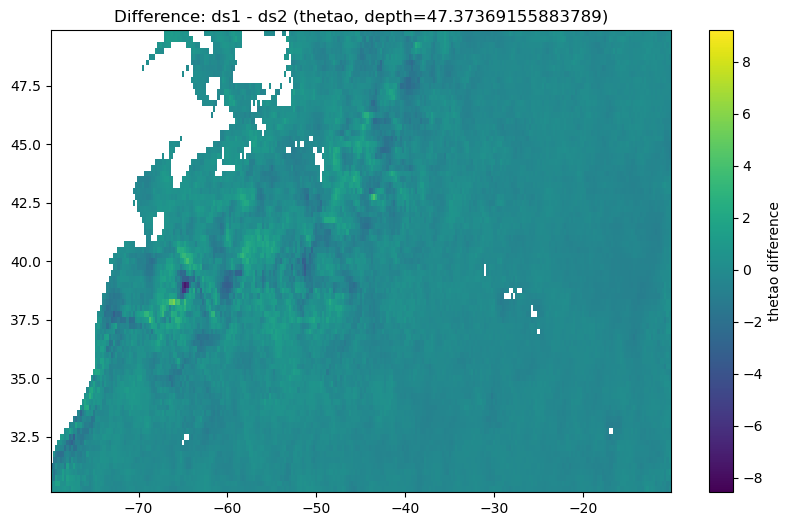

In [26]:
visualize_diffdifferences(normalrun_gulf, corrected_gulf, pmin, pmax, 'thetao', depth_idx=1)

In [27]:
diff_summary_gulf1 = summarize_difference(normalrun_gulf, glo12_gulf)
score_abs_mean_gulf1 = abs_mean_score(normalrun_gulf, glo12_gulf)
diff_summary_gulf2 = summarize_difference(corrected_gulf, glo12_gulf)
score_abs_mean_gulf2 = abs_mean_score(corrected_gulf, glo12_gulf)

In [28]:
# score_abs_mean_gulf1["zos"]
# score_abs_mean_gulf1["thetao"]
# score_abs_mean_gulf1["so"]
# score_abs_mean_gulf1["uo"]
score_abs_mean_gulf1["vo"]

{np.float32(0.494025): {'abs_mean_score': 0.7172962339488139},
 np.float32(47.37369): {'abs_mean_score': 0.5311599758393624},
 np.float32(92.32607): {'abs_mean_score': 0.5109058083831954},
 np.float32(155.8507): {'abs_mean_score': 0.49391998585362656},
 np.float32(222.4752): {'abs_mean_score': 0.4814226048415717},
 np.float32(318.1274): {'abs_mean_score': 0.4688792808635896},
 np.float32(380.213): {'abs_mean_score': 0.4645405806744423},
 np.float32(453.9377): {'abs_mean_score': 0.46272526631353794},
 np.float32(541.0889): {'abs_mean_score': 0.46562133674910283},
 np.float32(643.5668): {'abs_mean_score': 0.47552937956477515},
 np.float32(763.3331): {'abs_mean_score': 0.4955188495413169},
 np.float32(902.3393): {'abs_mean_score': 0.5784850700809395},
 np.float32(1245.291): {'abs_mean_score': 0.5598998747931407},
 np.float32(1684.284): {'abs_mean_score': 0.5504352274868606},
 np.float32(2225.078): {'abs_mean_score': 0.5665695898409019},
 np.float32(3220.82): {'abs_mean_score': 0.580821562

In [29]:
# score_abs_mean_gulf2["zos"]
# score_abs_mean_gulf2["thetao"]
# score_abs_mean_gulf2["so"]
# score_abs_mean_gulf2["uo"]
score_abs_mean_gulf2["vo"]

{np.float32(0.494025): {'abs_mean_score': 0.5373286049433594},
 np.float32(47.37369): {'abs_mean_score': 0.3519710097192169},
 np.float32(92.32607): {'abs_mean_score': 0.33311480344664235},
 np.float32(155.8507): {'abs_mean_score': 0.3195775453516282},
 np.float32(222.4752): {'abs_mean_score': 0.30972881009110537},
 np.float32(318.1274): {'abs_mean_score': 0.3002653372431564},
 np.float32(380.213): {'abs_mean_score': 0.29768180430373514},
 np.float32(453.9377): {'abs_mean_score': 0.29730117136817646},
 np.float32(541.0889): {'abs_mean_score': 0.29820349287641923},
 np.float32(643.5668): {'abs_mean_score': 0.30546574461121956},
 np.float32(763.3331): {'abs_mean_score': 0.3204008186975927},
 np.float32(902.3393): {'abs_mean_score': 0.3883506542738723},
 np.float32(1245.291): {'abs_mean_score': 0.37279045010558337},
 np.float32(1684.284): {'abs_mean_score': 0.36609926297375117},
 np.float32(2225.078): {'abs_mean_score': 0.37585891245292646},
 np.float32(3220.82): {'abs_mean_score': 0.3831